# TensorFlow를 활용한 시계열 예측 모델 학습 예시
이번에는 TensorFlow와 Keras를 활용한 시계열 예측(Time Series Forecasting) 모델 학습 예시를 좀 더 난이도 있게 구성해 보았습니다. 
시계열 데이터는 순차적인 특성을 가지고 있기 때문에 이를 모델링하는 데에는 순환 신경망(Recurrent Neural Networks, RNN) 계열의 모델, 
특히 **LSTM(Long Short-Term Memory)**이 많이 사용됩니다.

이 예시에서는 가상의 시계열 데이터를 생성하여 LSTM 모델을 학습시키고, 미래 값을 예측하는 과정을 보여드릴게요.

# TensorFlow를 활용한 시계열 예측 모델 학습 예시 (설명 부분)

---

## 1. 필요한 라이브러리 임포트

모델 학습을 위해 필요한 주요 라이브러리들을 불러오는 단계입니다. 이 라이브러리들은 데이터 생성, 전처리, 모델 구축 및 시각화 등 다양한 작업에 활용됩니다.

* `tensorflow`: 구글에서 개발한 오픈소스 머신러닝 라이브러리입니다. 신경망 모델을 만들고 훈련시키는 핵심 도구로 사용됩니다.
* `tensorflow.keras.models.Sequential`: Keras의 Sequential API를 사용하여 레이어를 순차적으로 쌓아 올리는 모델을 정의합니다.
* `tensorflow.keras.layers.LSTM, Dense, Dropout`: 신경망의 각 층(Layer)을 정의하는 클래스입니다.
    * **`LSTM` (Long Short-Term Memory):** 시계열 데이터와 같이 순서가 중요한 데이터를 처리하는 데 특화된 특별한 종류의 순환 신경망(RNN) 레이어입니다. 과거 정보를 '기억'하고 '잊는' 능력이 뛰어나 시계열 예측에 특히 유용합니다.
    * **`Dense`:** 일반적인 신경망 레이어로, 모든 입력 뉴런이 모든 출력 뉴런과 연결된 형태입니다. 주로 모델의 마지막 단계에서 예측 값을 출력하는 데 사용됩니다.
    * **`Dropout`:** 과적합(Overfitting)을 방지하기 위한 기술입니다. 학습 과정에서 임의의 뉴런들을 일시적으로 비활성화시켜 모델이 특정 뉴런에 과도하게 의존하는 것을 막습니다.
* `sklearn.preprocessing.MinMaxScaler`: scikit-learn 라이브러리에서 제공하는 데이터 정규화(Normalization) 도구입니다. 데이터의 값을 특정 범위(예: 0과 1 사이)로 조정하여 모델 학습을 더 안정적으로 만듭니다.
* `numpy as np`: 파이썬에서 수치 계산을 효율적으로 할 수 있게 해주는 라이브러리입니다. 배열(array) 연산에 주로 사용됩니다.
* `matplotlib.pyplot as plt`: 데이터를 시각화(그래프 그리기)하는 데 사용되는 라이브러리입니다.
* `pandas as pd`: 데이터를 구조화하고 분석하는 데 유용한 라이브러리입니다. 주로 표 형태의 데이터(DataFrame)를 다룰 때 사용됩니다.

---

## 2. 시계열 데이터(Time Series Data)란 무엇인가요? & 가상의 시계열 데이터 생성

### 시계열 데이터(Time Series Data)란?

**시계열 데이터**는 말 그대로 **'시간의 흐름에 따라 기록된 데이터'**를 의미해요. 시간이 변함에 따라 측정된 값들이 순서대로 나열된 형태죠. 일반적인 데이터와 가장 큰 차이점은 데이터 포인트들 사이에 **시간적인 순서와 의존성**이 있다는 점이에요. 즉, 과거의 데이터가 미래의 데이터에 영향을 미치거나 관련이 있다는 거죠.

일상생활에서 시계열 데이터를 아주 쉽게 찾아볼 수 있어요.

* **주식 가격:** 매일매일 변하는 주식의 종가. 어제 주가가 오늘 주가에 영향을 미치겠죠?
* **기온 변화:** 시간(일, 월, 년)에 따라 기록되는 평균 기온. 여름 기온이 겨울 기온보다 높은 경향이 있듯 계절적인 패턴이 있어요.
* **판매량:** 월별, 분기별 특정 제품의 판매량.

이런 시계열 데이터를 분석하고 예측하는 것은 주가 예측, 일기 예보, 교통량 예측 등 다양한 분야에서 매우 중요하게 활용됩니다.

### 가상의 시계열 데이터 생성 코드 설명

이제 가상의 시계열 데이터를 직접 만들어볼 시간입니다. 실제 데이터를 사용하는 대신, 시계열 데이터가 가질 수 있는 여러 특징(추세, 주기성, 불규칙성)을 흉내 내어 가상의 데이터를 만드는 부분입니다.

#### 데이터 생성 파라미터(변수들)

아래 변수들은 가상 시계열 데이터의 특징을 정의하는 값들입니다.

* `n_steps = 1000`
    * **역할:** 우리가 만들 시계열 데이터의 **전체 길이**, 즉 **총 몇 개의 데이터 포인트(관측치)**를 만들 것인지를 정하는 변수입니다. 여기서는 1000개의 데이터 포인트를 만들겠다는 의미예요.
* `time = np.arange(n_steps)`
    * **역할:** `0, 1, 2, ..., 999`와 같이 **시간 순서를 나타내는 숫자 배열**을 만듭니다. `n_steps`가 1000이므로 0부터 999까지의 숫자가 들어있는 배열이 만들어지겠죠. 이 `time` 배열은 나중에 사인파(주기성)나 선형 추세(점점 증가하거나 감소하는 경향)를 만들 때 사용됩니다.
* `amplitude = 10`
    * **역할:** **주기적인 패턴(사인파)**의 **높이(최대 진폭)**를 결정합니다. 이 값이 크면 사인파의 오르내림 폭이 커지고, 작으면 오르내림 폭이 작아집니다.
* `period = 50`
    * **역할:** **주기적인 패턴(사인파)**의 **주기**를 결정합니다. 즉, 몇 개의 시간 단위를 거쳐야 패턴이 한 번 반복되는지를 나타냅니다. `period`가 50이면 50개의 시간 단위를 지날 때마다 비슷한 패턴이 다시 나타난다는 의미입니다.
* `trend_slope = 0.05`
    * **역할:** **전체적인 추세(경향성)**의 **기울기**를 결정합니다. 이 값이 양수이면 시간이 지날수록 데이터 값이 점차 증가하는 '상승 추세'를 보이고, 음수이면 '하락 추세'를 보입니다. 0이면 추세가 없는 거죠. 여기서는 0.05이므로 약간씩 증가하는 경향을 갖게 됩니다.
* `noise_amplitude = 2`
    * **역할:** 시계열 데이터에 추가될 **불규칙한 잡음(노이즈)**의 **크기**를 결정합니다. 실제 데이터는 완벽하게 규칙적이지 않고 항상 예측 불가능한 작은 변화들이 포함되어 있는데, 이 노이즈가 그런 불규칙성을 나타냅니다. 이 값이 클수록 데이터가 더 들쭉날쭉해집니다.

#### 시계열 데이터 구성 요소 생성

위에서 정의한 변수들을 활용하여 시계열 데이터의 세 가지 주요 구성 요소를 만듭니다.

* **`series = amplitude * np.sin(time / period * 2 * np.pi)` (사인파 - 계절성)**
    * 이 부분은 데이터에 **주기적인 패턴(계절성)**을 추가합니다. 예를 들어, 여름에는 에어컨 판매량이 늘고 겨울에는 줄어드는 것처럼 특정 주기마다 반복되는 현상을 '계절성'이라고 합니다.
    * `np.sin()` 함수는 주기적인 파동을 만드는 데 사용됩니다. `time`, `period`, `amplitude` 변수가 이 파동의 모양을 결정합니다. 쉽게 말해, 50번의 시간마다 높낮이가 반복되는 물결 모양을 그린다고 생각하시면 됩니다.
* **`series += trend_slope * time` (선형 추세)**
    * 이 부분은 데이터에 **전체적인 경향(추세)**을 추가합니다. 시간이 지남에 따라 데이터 값이 꾸준히 증가하거나(상승 추세) 감소하는(하락 추세) 경향을 의미해요.
    * `trend_slope * time`은 `time`이 증가할수록 `series` 값도 비례해서 증가하도록 만듭니다. (만약 `trend_slope`가 음수면 감소하겠죠.)
* **`np.random.seed(42)` (재현성을 위한 시드 설정)**
    * **`seed`**는 컴퓨터가 '랜덤'한 숫자를 만들어낼 때 사용하는 시작점 같은 역할을 해요. 컴퓨터는 완전히 무작위로 숫자를 만들 수 없기 때문에 어떤 규칙에 따라 숫자를 만드는데, `seed` 값을 정해주면 항상 **똑같은 순서의 랜덤한 숫자**를 만들어낼 수 있습니다.
    * **역할:** 이 코드를 여러 번 실행해도 항상 똑같은 '노이즈'가 생성되도록 하여, 실험 결과를 **재현**할 수 있게 해줍니다. 만약 이 부분이 없다면, 코드를 실행할 때마다 다른 노이즈가 생성되어 그래프 모양이 조금씩 달라질 수 있습니다.
* **`noise = noise_amplitude * np.random.randn(n_steps)` (노이즈 추가)**
    * `np.random.randn(n_steps)`는 평균이 0이고 표준편차가 1인 **랜덤한 숫자(노이즈)**를 `n_steps` 개만큼 만듭니다.
    * 여기에 `noise_amplitude`를 곱하여 노이즈의 크기를 조절합니다. 이 노이즈는 실제 데이터가 항상 예측 불가능한 작은 변동을 포함하는 것을 흉내 냅니다.
    * `series += noise`는 이렇게 만들어진 노이즈를 앞서 만든 사인파와 추세가 더해진 `series`에 더해주는 것입니다.

#### DataFrame으로 변환

* **`df = pd.DataFrame({'value': series})`**
    * `pd.DataFrame`은 파이썬의 **Pandas**라는 라이브러리에서 제공하는 **표 형태의 데이터 구조**입니다. 엑셀 스프레드시트와 비슷하다고 생각하시면 돼요.
    * 여기서는 위에서 만든 `series` 데이터를 `'value'`라는 이름의 열(column)로 가지는 데이터프레임 `df`를 만듭니다. 이렇게 하면 데이터를 더 쉽게 다루고 분석할 수 있습니다.

이 과정을 통해 우리는 시간의 흐름에 따라 **주기적인 패턴(계절성)**, **점진적인 변화(추세)**, 그리고 **예측 불가능한 잡음(노이즈)**이 모두 포함된 가상의 시계열 데이터를 만들게 됩니다. 이 데이터가 실제 시계열 데이터와 유사한 특성을 가지기 때문에, 이 데이터를 가지고 머신러닝 모델을 훈련시키면 실제 시계열 데이터를 다루는 방법을 연습할 수 있습니다.

---

## 3. 데이터 전처리 (정규화 및 시퀀스 생성)

모델이 데이터를 효율적으로 학습할 수 있도록 데이터를 준비하는 과정입니다.

* **데이터 정규화 (Normalization)**
    * **역할:** 머신러닝 모델, 특히 신경망은 입력 데이터의 스케일이 매우 클 때 학습이 불안정해지거나 느려질 수 있습니다. **정규화**는 데이터의 값을 특정 범위(예: 0에서 1 사이)로 조정하여 이러한 문제를 해결합니다.
    * `MinMaxScaler`: 이 도구는 데이터의 최소값을 0으로, 최대값을 1로 맞춰주는 방식으로 정규화합니다.
    * `scaled_data = scaler.fit_transform(df['value'].values.reshape(-1, 1))`: `df['value']` (우리가 만든 시계열 데이터)를 가져와 `reshape(-1, 1)`로 형태를 변경한 뒤, `fit_transform`을 사용하여 데이터를 정규화합니다. `fit`은 데이터의 최소/최대값을 학습하고, `transform`은 학습된 값을 이용해 데이터를 변환합니다.

* **시퀀스 데이터 생성 (Sequence Generation)**
    * **왜 필요한가요?:** LSTM과 같은 순환 신경망은 과거 데이터를 기반으로 미래를 예측합니다. 따라서 모델의 입력은 '과거 N개의 데이터'가 되고, 예측할 '다음 1개의 데이터'가 타겟이 됩니다. 이처럼 순차적인 묶음(시퀀스)을 만들어주는 과정이 필요합니다.
    * **`create_sequences(data, sequence_length)` 함수:**
        * `data`: 정규화된 시계열 데이터입니다.
        * `sequence_length`: 모델이 다음 값을 예측하기 위해 고려할 **과거 데이터의 길이**를 의미합니다. 예를 들어, `sequence_length`가 50이라면, 과거 50개의 데이터 포인트를 보고 그 다음 1개의 값을 예측하게 됩니다.
        * 이 함수는 `data`를 `sequence_length`만큼의 덩어리로 잘라 입력(`X`)을 만들고, 각 덩어리 바로 다음 값을 타겟(`y`)으로 설정하여 반환합니다.
    * `X, y = create_sequences(scaled_data, sequence_length)`: 정규화된 데이터를 이용해 입력(`X`)과 타겟(`y`) 시퀀스를 생성합니다.
    * `train_size = int(len(X) * 0.8)`: 전체 시퀀스 데이터의 80%를 **학습 데이터**로 사용하고, 나머지 20%를 **테스트 데이터**로 사용하기 위해 기준점을 정합니다.
    * `X_train, X_test`, `y_train, y_test`: 학습에 사용될 데이터(`_train`)와 모델 성능을 평가할 데 사용될 데이터(`_test`)로 나눕니다.
    * **`np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))` (LSTM 입력 형태 맞추기):**
        * LSTM 모델은 입력 데이터를 특정 형태(3D 텐서)로 요구합니다: `[샘플 수, 시퀀스 길이, 피처(특성) 수]`.
        * `X_train.shape[0]`는 샘플의 개수, `X_train.shape[1]`는 시퀀스 길이(과거 데이터 개수)를 나타냅니다.
        * 마지막 `1`은 '피처 수'를 의미합니다. 우리는 지금 하나의 시계열 값(단변량 시계열)만 사용하고 있기 때문에 피처 수가 1입니다. 여러 개의 시계열 데이터를 동시에 예측하는 다변량 시계열의 경우 이 값이 변경됩니다. `X_test`도 같은 방식으로 형태를 맞춰줍니다.

이 과정을 통해 모델이 학습할 수 있는 형태로 데이터가 준비됩니다.

In [4]:
# 1. 필요한 라이브러리 임포트
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

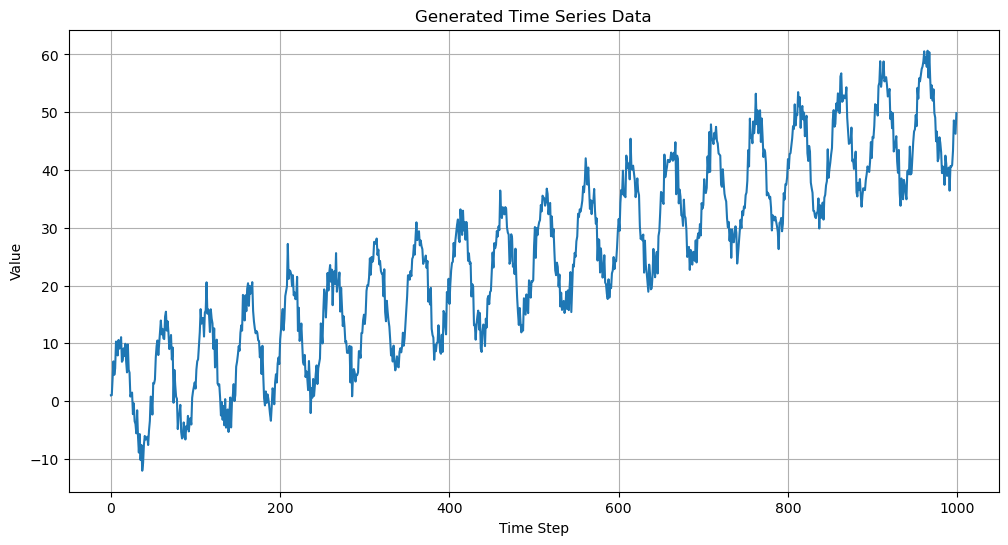

In [6]:
# 2. 가상의 시계열 데이터 생성
# 실제 데이터 대신 시뮬레이션된 시계열 데이터를 사용합니다. 여기서는 계절성과 추세가 있는 데이터를 만듭니다.
# 데이터 생성 파라미터
n_steps = 1000 # 총 데이터 포인트 수
time = np.arange(n_steps)
amplitude = 10
period = 50
trend_slope = 0.05
noise_amplitude = 2

# 사인파 (계절성)
series = amplitude * np.sin(time / period * 2 * np.pi)

# 선형 추세
series += trend_slope * time

# 노이즈 추가
np.random.seed(42) # 재현성을 위해 시드 설정
noise = noise_amplitude * np.random.randn(n_steps)
series += noise

# DataFrame으로 변환
df = pd.DataFrame({'value': series})

plt.figure(figsize=(12, 6))
plt.plot(df['value'])
plt.title('Generated Time Series Data')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [10]:
# 3. 데이터 전처리 (정규화 및 시퀀스 생성)
# 시계열 데이터는 일반적으로 Min-Max Scaling을 통해 정규화하여 모델 학습의 안정성을 높입니다. 
# 또한, LSTM 모델은 과거 데이터를 기반으로 미래를 예측하므로, 입력 시퀀스와 예측할 타겟 시퀀스를 생성해야 합니다.
# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['value'].values.reshape(-1, 1))

# 시퀀스 데이터 생성 함수
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length), 0])
        y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(y)

sequence_length = 50 # 과거 50개의 타임스텝을 보고 다음 타임스텝 예측
X, y = create_sequences(scaled_data, sequence_length)

# 데이터셋 분리 (학습 및 테스트)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# LSTM 입력 형태에 맞게 reshape: [샘플 수, 시퀀스 길이, 피처 수]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (760, 50, 1)
y_train shape: (760,)
X_test shape: (190, 50, 1)
y_test shape: (190,)


In [12]:
# 4. LSTM 모델 구축
# LSTM 레이어를 포함하는 Sequential 모델을 구축합니다. 
# return_sequences=True는 여러 LSTM 레이어를 쌓을 때 필요하며, 마지막 LSTM 레이어는 return_sequences=False로 설정하거나 
# 생략하여 Dense 레이어로 연결합니다. Dropout은 과적합을 방지하는 데 도움을 줍니다.
model = Sequential([
    LSTM(units=100, return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.3),
    LSTM(units=100, return_sequences=False),
    Dropout(0.3),
    Dense(units=1) # 예측할 다음 하나의 값을 위한 출력 레이어
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           40800     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/50
22/22 [==============================] - 2s 45ms/step - loss: 0.0388 - val_loss: 0.0066
Epoch 2/50
22/22 [==============================] - 1s 31ms/step - loss: 0.0085 - val_loss: 0.0094
Epoch 3/50
22/22 [==============================] - 1s 31ms/step - loss: 0.0070 - val_loss: 0.0094
Epoch 4/50
22/22 [==============================] - 1s 31ms/step - loss: 0.0056 - val_loss: 0.0051
Epoch 5/50
22/22 [==============================] - 1s 38ms/step - loss: 0.0041 - val_loss: 0.0095
Epoch 6/50
22/22 [==============================] - 1s 32ms/step - loss: 0.0039 - val_loss: 0.0047
Epoch 7/50
22/22 [==============================] - 1s 32ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 8/50
22/22 [==============================] - 1s 32ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 9/50
22/22 [==============================] - 1s 32ms/step - loss: 0.0032 - val_loss: 0.0013
Epoch 10/50
22/22 [==============================] - 1s 32ms/step - loss: 0.0034 - val_loss: 0.0013
Epoch 11/

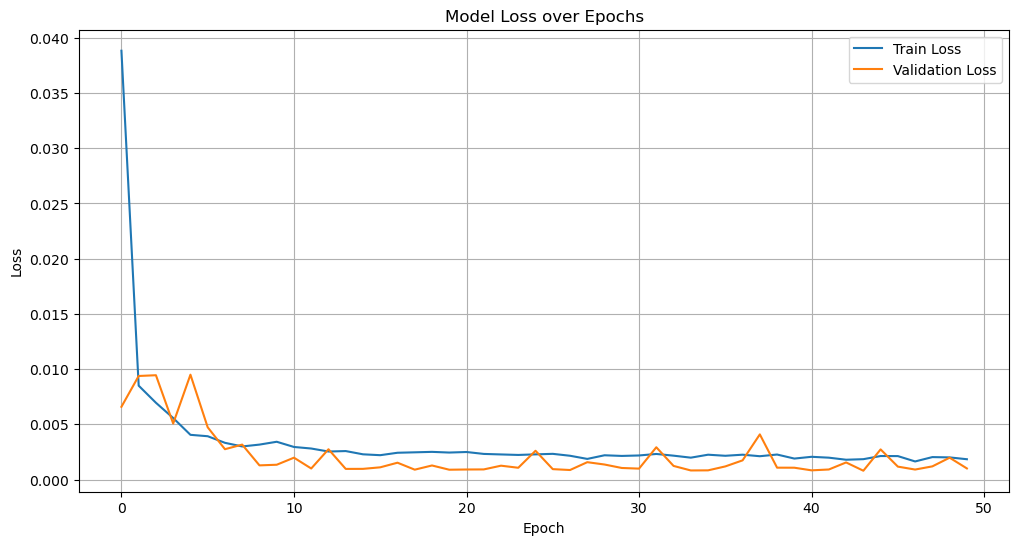

In [14]:
# 5. 모델 학습
# 모델을 학습시킵니다. validation_split을 통해 훈련 데이터의 일부를 검증용으로 사용하여 학습 진행 상황을 모니터링할 수 있습니다. 
# EarlyStopping과 ModelCheckpoint와 같은 콜백을 추가하여 학습을 더욱 효율적으로 관리할 수 있지만, 여기서는 간결성을 위해 생략했습니다.
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# 학습 과정 시각화
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

6/6 [==============================] - 0s 9ms/step


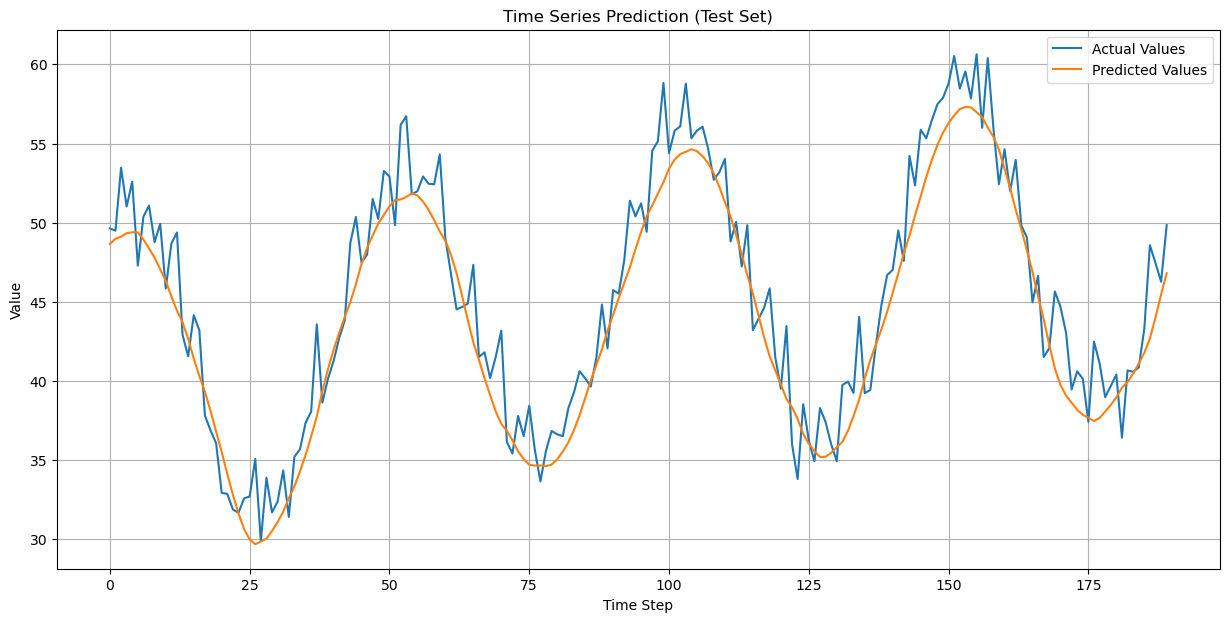

In [16]:
# 6. 모델 예측 및 결과 역정규화
# 학습된 모델을 사용하여 테스트 데이터에 대한 예측을 수행하고, 예측된 값을 원래 스케일로 역정규화합니다.
# 테스트 데이터 예측
predictions = model.predict(X_test)

# 예측값과 실제값을 원래 스케일로 역정규화
predictions = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# 예측 결과 시각화
plt.figure(figsize=(15, 7))
plt.plot(y_test_inverse, label='Actual Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Time Series Prediction (Test Set)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# 7. 성능 평가
# 회귀 모델의 성능 평가는 주로 MSE(Mean Squared Error)나 RMSE(Root Mean Squared Error), MAE(Mean Absolute Error) 등을 사용합니다.
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_test_inverse, predictions))
mae = mean_absolute_error(y_test_inverse, predictions)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Root Mean Squared Error (RMSE): 2.4822
Mean Absolute Error (MAE): 1.9992


코드 설명 및 난이도 향상 포인트
시계열 데이터의 특성: 단순히 개별 샘플이 아니라 시간 순서에 따라 의존성을 가지는 데이터의 특성을 이해하고 이를 모델에 반영하는 것이 중요합니다.
데이터 전처리:
Min-Max Scaling: 데이터의 스케일을 0과 1 사이로 맞춰 모델 학습을 안정화합니다.
시퀀스 생성: LSTM 모델의 입력은 3D 텐서 형태([samples, timesteps, features])이므로, sequence_length만큼의 과거 데이터를 묶어 하나의 입력 시퀀스로 만들고, 다음 값을 타겟으로 설정하는 과정이 필수적입니다.
LSTM 레이어:
units: LSTM 셀의 출력 차원(메모리 셀의 개수)을 설정합니다.
return_sequences=True: LSTM 레이어 다음에 또 다른 LSTM 레이어를 쌓을 경우, 현재 LSTM 레이어가 다음 시퀀스를 반환하도록 설정합니다. 마지막 LSTM 레이어에서는 일반적으로 False로 설정하여 Dense 레이어로 연결할 수 있도록 합니다.
Dropout 레이어: 과적합(Overfitting)을 방지하기 위해 학습 시 랜덤하게 뉴런의 일부를 비활성화합니다.
다층 LSTM: 단일 LSTM 레이어 대신 여러 LSTM 레이어를 쌓아 모델의 복잡성과 학습 능력을 높일 수 있습니다.
시각화: 생성된 데이터, 학습 과정의 손실, 예측 결과 등을 시각화하여 모델의 작동 방식과 성능을 직관적으로 이해할 수 있습니다.
이 예시는 시계열 데이터의 기본적인 예측 흐름을 보여줍니다. 실제 시계열 예측에서는 더 복잡한 피처 엔지니어링, 다양한 모델 아키텍처(GRU, Conv1D + LSTM 등), 다변량 시계열, 계절성 분해, 이상치 처리 등 고려할 요소가 많아집니다.

1. 통계적 시계열 분해 (Statistical Time Series Decomposition)
가장 일반적이고 직관적인 방법입니다. statsmodels 라이브러리의 seasonal_decompose 함수를 사용하면 시계열 데이터를 추세, 계절성, 잔차의 세 가지 구성 요소로 분리하여 시각화하고 각 구성 요소의 특성을 파악할 수 있습니다.

추세(Trend): 장기적인 증가 또는 감소 경향. trend_slope와 같은 개념을 시각적으로 파악할 수 있습니다.
계절성(Seasonality): 일정한 주기로 반복되는 패턴. period와 amplitude와 같은 주기적인 특성을 확인할 수 있습니다.
잔차(Residual): 추세와 계절성으로 설명되지 않는 불규칙한 변동 또는 노이즈.

<Figure size 1200x800 with 0 Axes>

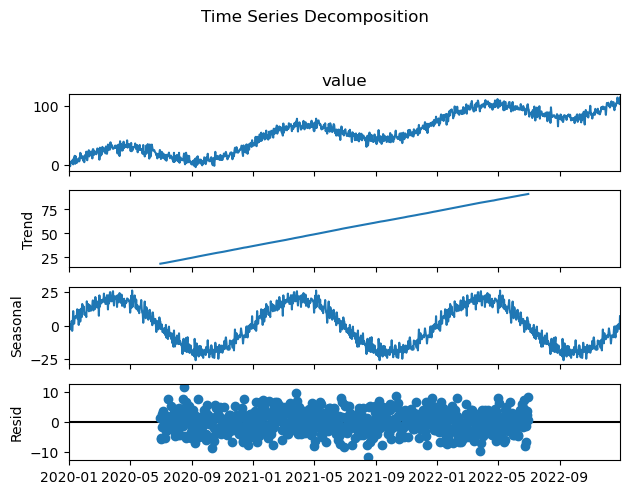

추세 컴포넌트의 첫 5개 값:
2020-01-01   NaN
2020-01-02   NaN
2020-01-03   NaN
2020-01-04   NaN
2020-01-05   NaN
Freq: D, Name: trend, dtype: float64

계절성 컴포넌트의 첫 5개 값:
2020-01-01   -1.153295
2020-01-02   -0.809779
2020-01-03   -1.900222
2020-01-04   -1.030536
2020-01-05    0.965788
Freq: D, Name: seasonal, dtype: float64

잔차 컴포넌트의 첫 5개 값:
2020-01-01   NaN
2020-01-02   NaN
2020-01-03   NaN
2020-01-04   NaN
2020-01-05   NaN
Freq: D, Name: resid, dtype: float64


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# 가상의 시계열 데이터 다시 생성 (이전 예제와 동일)
n_steps = 365 * 3 # 3년치 일별 데이터 가정
time = np.arange(n_steps)
amplitude = 20
period = 365 # 1년 주기 (계절성)
trend_slope = 0.1
noise_amplitude = 5

series = amplitude * np.sin(time / period * 2 * np.pi) + trend_slope * time + noise_amplitude * np.random.randn(n_steps)
df_decomp = pd.DataFrame({'value': series}, index=pd.to_datetime(pd.date_range(start='2020-01-01', periods=n_steps, freq='D')))

# 시계열 분해 수행
# model='additive'는 추세+계절성+잔차 형태로, 'multiplicative'는 추세*계절성*잔차 형태로 분해
# period는 계절성의 주기를 직접 지정해야 합니다 (예: 일별 데이터에서 1년 주기는 365)
decomposition = seasonal_decompose(df_decomp['value'], model='additive', period=365)

# 분해 결과 시각화
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.suptitle('Time Series Decomposition', y=1.02) # 전체 제목 위치 조정
plt.tight_layout(rect=[0, 0, 1, 0.98]) # 플롯 간격 조정
plt.show()

# 각 구성 요소 접근
# trend_component = decomposition.trend
# seasonal_component = decomposition.seasonal
# residual_component = decomposition.resid

print(f"추세 컴포넌트의 첫 5개 값:\n{decomposition.trend.head()}")
print(f"\n계절성 컴포넌트의 첫 5개 값:\n{decomposition.seasonal.head()}")
print(f"\n잔차 컴포넌트의 첫 5개 값:\n{decomposition.resid.head()}")

2. 푸리에 변환 (Fourier Transform)을 이용한 주기성 분석
데이터에 숨어있는 **주기(Period)**를 정량적으로 찾아낼 때 유용합니다. 푸리에 변환은 시계열 데이터를 여러 개의 사인파와 코사인파의 합으로 분해하여, 어떤 주기의 파동이 데이터에 가장 큰 영향을 미치는지(즉, 어떤 주기가 가장 강하게 나타나는지) 알려줍니다.

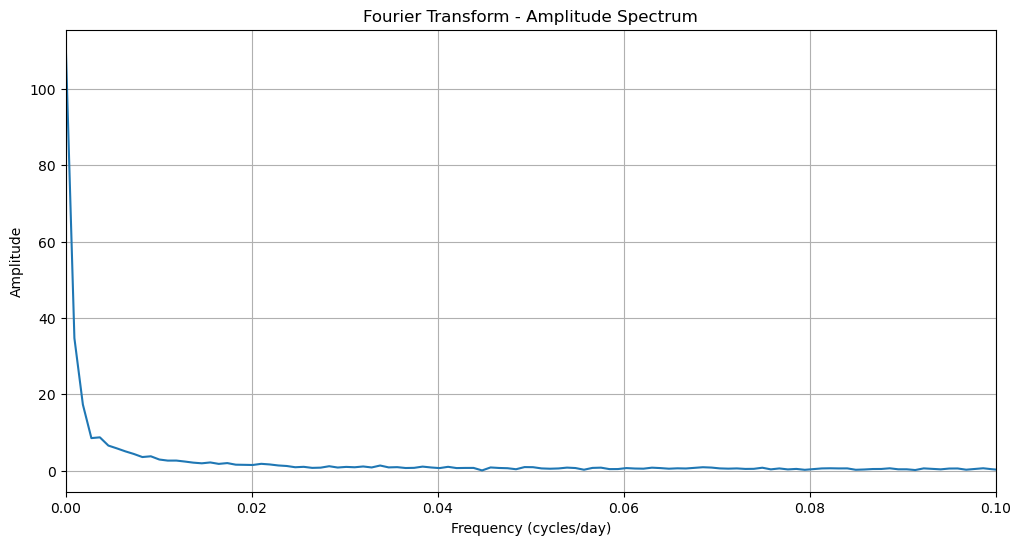

가장 강한 주파수 (Frequency): 0.0009 cycles/day
해당 주파수의 주기 (Period): 1095.00 days

상위 5개 주요 주기(대략적): [182 219 274 365 548] days


In [32]:
from scipy.fftpack import fft, fftfreq

# 위에 생성된 df_decomp['value'] 데이터 사용
signal = df_decomp['value'].values
N = len(signal) # 샘플 수
T = 1 # 샘플링 간격 (일별 데이터이므로 1일)

yf = fft(signal)
xf = fftfreq(N, T)[:N//2] # 주파수 축 (절반만 필요)

# 진폭 스펙트럼 계산
amplitude_spectrum = 2.0/N * np.abs(yf[0:N//2])

plt.figure(figsize=(12, 6))
plt.plot(xf, amplitude_spectrum)
plt.title('Fourier Transform - Amplitude Spectrum')
plt.xlabel('Frequency (cycles/day)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.xlim(0, 0.1) # 특정 주파수 범위만 보기 (예: 0.1은 10일에 한 번 반복)
plt.show()

# 가장 강한 주파수 찾기
peak_frequency_idx = np.argmax(amplitude_spectrum[1:]) + 1 # 0Hz 제외
peak_frequency = xf[peak_frequency_idx]
print(f"가장 강한 주파수 (Frequency): {peak_frequency:.4f} cycles/day")
print(f"해당 주파수의 주기 (Period): {1/peak_frequency:.2f} days")

# 여러 주기가 있을 경우 상위 N개 주파수 확인
sorted_indices = np.argsort(amplitude_spectrum)[::-1]
top_periods = []
for i in sorted_indices:
    if xf[i] > 0.001: # 0Hz (DC component) 및 매우 낮은 주파수 제외
        top_periods.append(1/xf[i])
        if len(top_periods) >= 5: # 상위 5개 주기만 확인
            break
print(f"\n상위 5개 주요 주기(대략적): {np.unique(np.round(top_periods)).astype(int)} days")

이 그래프에서 높은 봉우리가 있는 곳이 해당 주파수(Frequency)가 강하게 나타나는 지점입니다. 주파수의 역수가 주기가 됩니다. 예를 들어, 주파수 0.0027 cycle/day는 1/0.0027 = 약 365일을 의미하며, 1년 주기 계절성이 강하다는 것을 나타냅니다.

3. 통계 모델을 이용한 추세 및 계절성 파라미터 추정
ARIMA, SARIMA, Prophet 등의 통계 모델들은 시계열 데이터의 추세와 계절성을 모델링하는 데 사용됩니다. 이 모델들을 학습시키면, 내부적으로 추세의 강도나 계절성의 주기 및 강도 등을 추정하게 됩니다.

ARIMA (AutoRegressive Integrated Moving Average): 과거 자신의 값(AR), 과거 예측 오차(MA), 그리고 차분(I)을 통해 추세를 제거하는 방식으로 시계열을 모델링합니다.
SARIMA (Seasonal ARIMA): ARIMA에 계절성 요소를 추가한 모델입니다. 계절성의 주기와 강도를 파라미터로 포함합니다.
Prophet (Facebook): 페이스북에서 개발한 모델로, 추세, 계절성(다중 계절성 지원), 휴일 효과 등을 쉽게 모델링할 수 있습니다. trend_slope나 amplitude, period를 직접적으로 반환하진 않지만, 이들의 영향을 모델 내부에서 추정하고 시각적으로 보여줍니다.

In [40]:
# !pip install prophet

00:03:06 - cmdstanpy - INFO - Chain [1] start processing
00:03:06 - cmdstanpy - INFO - Chain [1] done processing


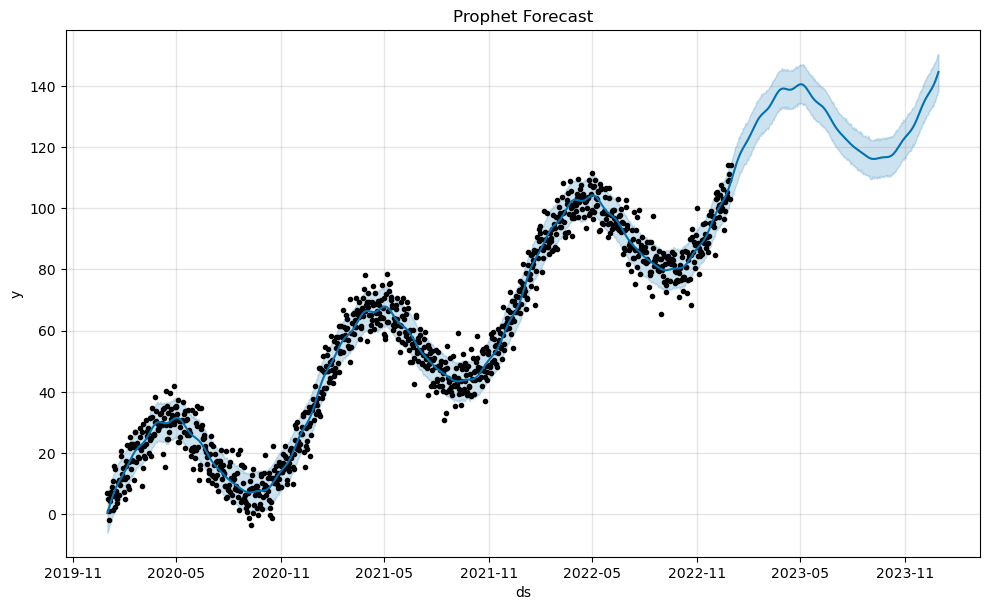

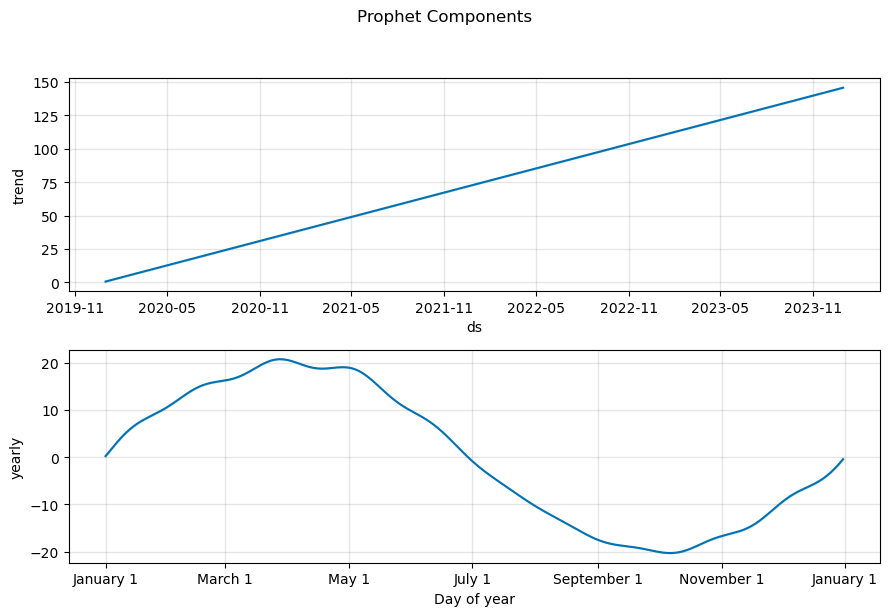

In [42]:
# Prophet 설치: pip install prophet
from prophet import Prophet

# 데이터 준비 (Prophet은 컬럼 이름이 'ds'와 'y'여야 합니다)
df_prophet = df_decomp.reset_index().rename(columns={'index': 'ds', 'value': 'y'})

# Prophet 모델 생성 및 학습
model_prophet = Prophet(
    seasonality_mode='additive', # 계절성 모드: additive 또는 multiplicative
    yearly_seasonality=True,     # 연간 계절성 사용 여부
    weekly_seasonality=False,    # 주간 계절성 사용 여부 (필요하면 True)
    daily_seasonality=False,     # 일간 계절성 사용 여부 (필요하면 True)
    growth='linear'              # 추세 모델: linear 또는 logistic
)
model_prophet.fit(df_prophet)

# 미래 예측을 위한 데이터프레임 생성
future = model_prophet.make_future_dataframe(periods=365) # 1년치 미래 예측

# 예측 수행
forecast = model_prophet.predict(future)

# 예측 결과 및 구성 요소 시각화
fig = model_prophet.plot(forecast)
plt.title('Prophet Forecast')
plt.show()

fig2 = model_prophet.plot_components(forecast)
plt.suptitle('Prophet Components', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

# Prophet은 추세의 변화점을 자동으로 감지하여 시각화해주므로
# trend_slope의 '변화'를 시각적으로 확인할 수 있습니다.
# 계절성 컴포넌트 그래프에서 amplitude와 period를 간접적으로 확인할 수 있습니다.